In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.4 MB/s eta 0:00:00


In [2]:
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob, pickle
import os
import warnings
warnings.filterwarnings("ignore")
# 경고메세지 생략, 오류메세지만 나오도록함.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '2'

import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Attention, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
import tensorflow_addons as tfa
import tensorflow as tf

from tensorflow.keras import optimizers
from tensorflow.keras.layers import Flatten, BatchNormalization, Input, Add, LeakyReLU, ReLU
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.model_selection import train_test_split
from sklearn.metrics import  multilabel_confusion_matrix, multilabel_confusion_matrix, log_loss
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, precision_recall_curve
from sklearn.preprocessing import Binarizer, minmax_scale

In [3]:
base_dir = "/content/drive/MyDrive/audio_project"
# 기본 direction 이동. 원래는 /content
os.chdir(base_dir)

# zipfile access
zip_access = zipfile.ZipFile('audio_data_all.zip','r')

name_list = zip_access.namelist()
# name_list 첫 번쨰 원소: '감정 분류 Mels, Mffc, Voice quality data/test_labels.pkl'

# 확장자별 파일 이름 분류
pkl_file = []
csv_file = []

for file_name in name_list:
    # 확장자 파일명확인
    ext_name = file_name.split('.')[-1]
    if ext_name == 'pkl':
        pkl_file.append(file_name)
    elif ext_name == 'csv':
        csv_file.append(file_name)

print(f"저장된 파일: \n{pkl_file}") # 저장된 파일 확인

저장된 파일: 
['감정 분류 Mels, Mffc, Voice quality data/test_labels.pkl', '감정 분류 Mels, Mffc, Voice quality data/test_labels_sets.pkl', '감정 분류 Mels, Mffc, Voice quality data/test_mels_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/test_mfcc_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/train_labels.pkl', '감정 분류 Mels, Mffc, Voice quality data/train_labels_sets.pkl', '감정 분류 Mels, Mffc, Voice quality data/train_mels_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/train_mfcc_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/val_labels.pkl', '감정 분류 Mels, Mffc, Voice quality data/val_labels_sets.pkl', '감정 분류 Mels, Mffc, Voice quality data/val_mels_data.pkl', '감정 분류 Mels, Mffc, Voice quality data/val_mfcc_data.pkl']


In [4]:
# mfcc 데이
idx = [0,1,3,4,5,7,8,9,11]
pkl_file = [pkl_file[idx] for idx in idx]

for pkl in pkl_file:
    with zip_access.open(pkl) as pickle_file:
        # 확장자 명을 제외한 부분을 변수명으로. ex) test_labels
        name = pkl.split('/')[-1].strip(".pkl")
        globals()["{}".format(name)] = pickle.load(pickle_file)

# lstm 모델 적용시 사용
def lstm_data_trans(arr):
    arr = np.array([i.transpose() for i in arr])
    return arr

X_train, y_train = lstm_data_trans(train_mfcc_data), np.array(train_labels_sets)
X_test, y_test = lstm_data_trans(test_mfcc_data), np.array(test_labels_sets)
X_val, y_val = lstm_data_trans(val_mfcc_data), np.array(val_labels_sets)

print(f'X_train shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test.shape: {y_test.shape}')
print(f'X_val shape: {X_val.shape}, y_val.shape: {y_val.shape}')

X_train shape: (71340, 300, 40), y_train.shape: (71340, 5)
X_test shape: (12849, 300, 40), y_test.shape: (12849, 5)
X_val shape: (11968, 300, 40), y_val.shape: (11968, 5)


In [5]:
input_shape = (300,40)
n_classes = 5

learning_rate = 0.0006
weight_decay = 0.0001
batch_size = 256
num_epochs = 50

In [6]:
def bilstm_dropout():

    model = Sequential()
    model.add(Bidirectional(LSTM(150, dropout = 0.2,return_sequences=True), merge_mode='ave', input_shape=input_shape))
    model.add(Bidirectional(LSTM(100, dropout = 0.2,return_sequences=True), merge_mode='ave'))
    model.add(Bidirectional(LSTM(40, dropout = 0.2, return_sequences = True), merge_mode='ave'))
    model.add(Bidirectional(LSTM(20)))
    model.add(Dropout(0.3))
    model.add(Dense(5, activation = 'sigmoid'))

    return model

model = bilstm_dropout()
print(model.summary())

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(optimizer=optimizer, loss ='binary_crossentropy', metrics= [tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
    #val데이터셋의 손실함수값을 최소화하는 것을 모니터링 하겠다. 멈추면 출력하겠다.(verbose) 성능이 향상되지 않아도 5걸음 나아가겠다.
    earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 6, verbose =1, mode = 'min' )
    mc = ModelCheckpoint('best_model.hdf5', monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
    history = model.fit(X_train, y_train,
                 validation_data=(X_val, y_val),
                 epochs=num_epochs,
                 batch_size=batch_size,
                 callbacks=[earlystopping,mc])

    return history, model

history,model = run_experiment(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 300, 150)          229200    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 300, 100)          200800    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 300, 40)           45120     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 40)                9760      
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 40)                0

In [7]:
def plot_history(history):

    plt.figure(figsize=(10 ,5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epcohs', weight = 'bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs', weight = 'bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 그래프 보이기
    plt.show()

def calculate_metrics(y_test, y_pred):
    label = ['happiness','sadness','angry','neutral','disgust']
    num_classes = 5
    accuracy = np.zeros(num_classes)
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)
    # sigmoid threshold에 맞게 값 변환

    # 저장되어 있는 주소 때문에 새로운 주소에 copy해야 원래 리스트가 변하지 않는다.
    cal_pred = y_pred.copy()
    cal_test = y_test.copy()

    for a in range(len(cal_pred)):
        for b in range(num_classes):
            if cal_pred[a][b] >= threshold_list[b]:
                cal_pred[a][b] = 1
            else:
                cal_pred[a][b] = 0

    for i in range(num_classes):
        true_positives = np.sum((cal_test[:, i] == 1) & (cal_pred[:, i] == 1))
        false_positives = np.sum((cal_test[:, i] == 0) & (cal_pred[:, i] == 1))
        false_negatives = np.sum((cal_test[:, i] == 1) & (cal_pred[:, i] == 0))
        true_negatives = np.sum((cal_test[:, i] == 0) & (cal_pred[:, i] == 0))
        accuracy[i] = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives + 1e-10)
        precision[i] = true_positives / (true_positives + false_positives + 1e-10)
        recall[i] = true_positives / (true_positives + false_negatives + 1e-10)
        f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-10)

        print(f"{label[i]} --- Accuracy: {accuracy[i]:.4f}, Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1: {f1_score[i]:.4f} \n")
    return cal_pred

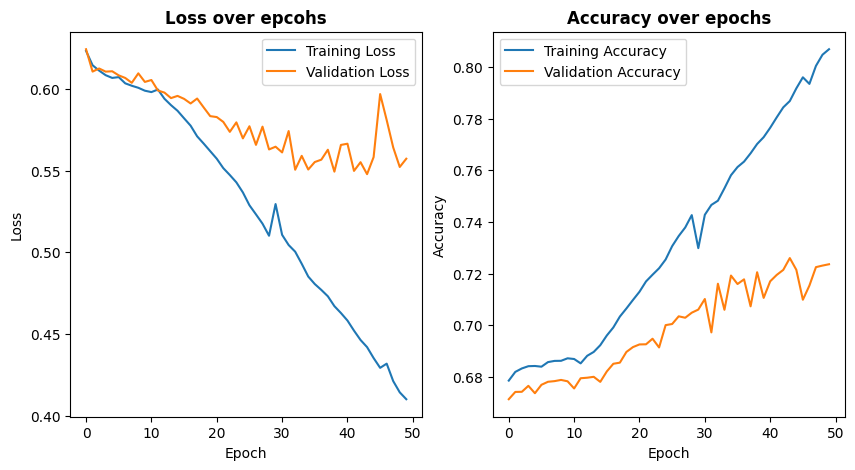

In [8]:
plot_history(history)

In [9]:
y_pred = model.predict(X_test)

# label이 0인 경우가 1인 경우보다 많음. 불균형에 의해 예측값이 0에 가까워짐.
# threshold 값이 0.5보다 낮은게 더 설명력이 높음
print("\nthreshold값 0.4 통일")
threshold_list = [0.4,0.4,0.4,0.4,0.4]
cal_pred1 = calculate_metrics(y_test, y_pred) # calculated 된 pred

print("\nthreshold값 0.5 통일")
threshold_list = [0.5,0.5,0.5,0.5,0.5]
cal_pred2 = calculate_metrics(y_test, y_pred) # calculated 된 pred

402/402 [==============================] - 17s 36ms/step

threshold값 0.4 통일
happiness --- Accuracy: 0.8024, Precision: 0.6730, Recall: 0.5219, F1: 0.5879 

sadness --- Accuracy: 0.6646, Precision: 0.5702, Recall: 0.6163, F1: 0.5924 

angry --- Accuracy: 0.6248, Precision: 0.4327, Recall: 0.6871, F1: 0.5310 

neutral --- Accuracy: 0.6832, Precision: 0.5681, Recall: 0.5917, F1: 0.5797 

disgust --- Accuracy: 0.7827, Precision: 0.6500, Recall: 0.4072, F1: 0.5007 


threshold값 0.5 통일
happiness --- Accuracy: 0.8092, Precision: 0.7289, Recall: 0.4671, F1: 0.5694 

sadness --- Accuracy: 0.6823, Precision: 0.6401, Recall: 0.4488, F1: 0.5277 

angry --- Accuracy: 0.6639, Precision: 0.4625, Recall: 0.5383, F1: 0.4975 

neutral --- Accuracy: 0.6925, Precision: 0.6225, Recall: 0.4247, F1: 0.5049 

disgust --- Accuracy: 0.7878, Precision: 0.7147, Recall: 0.3447, F1: 0.4651 



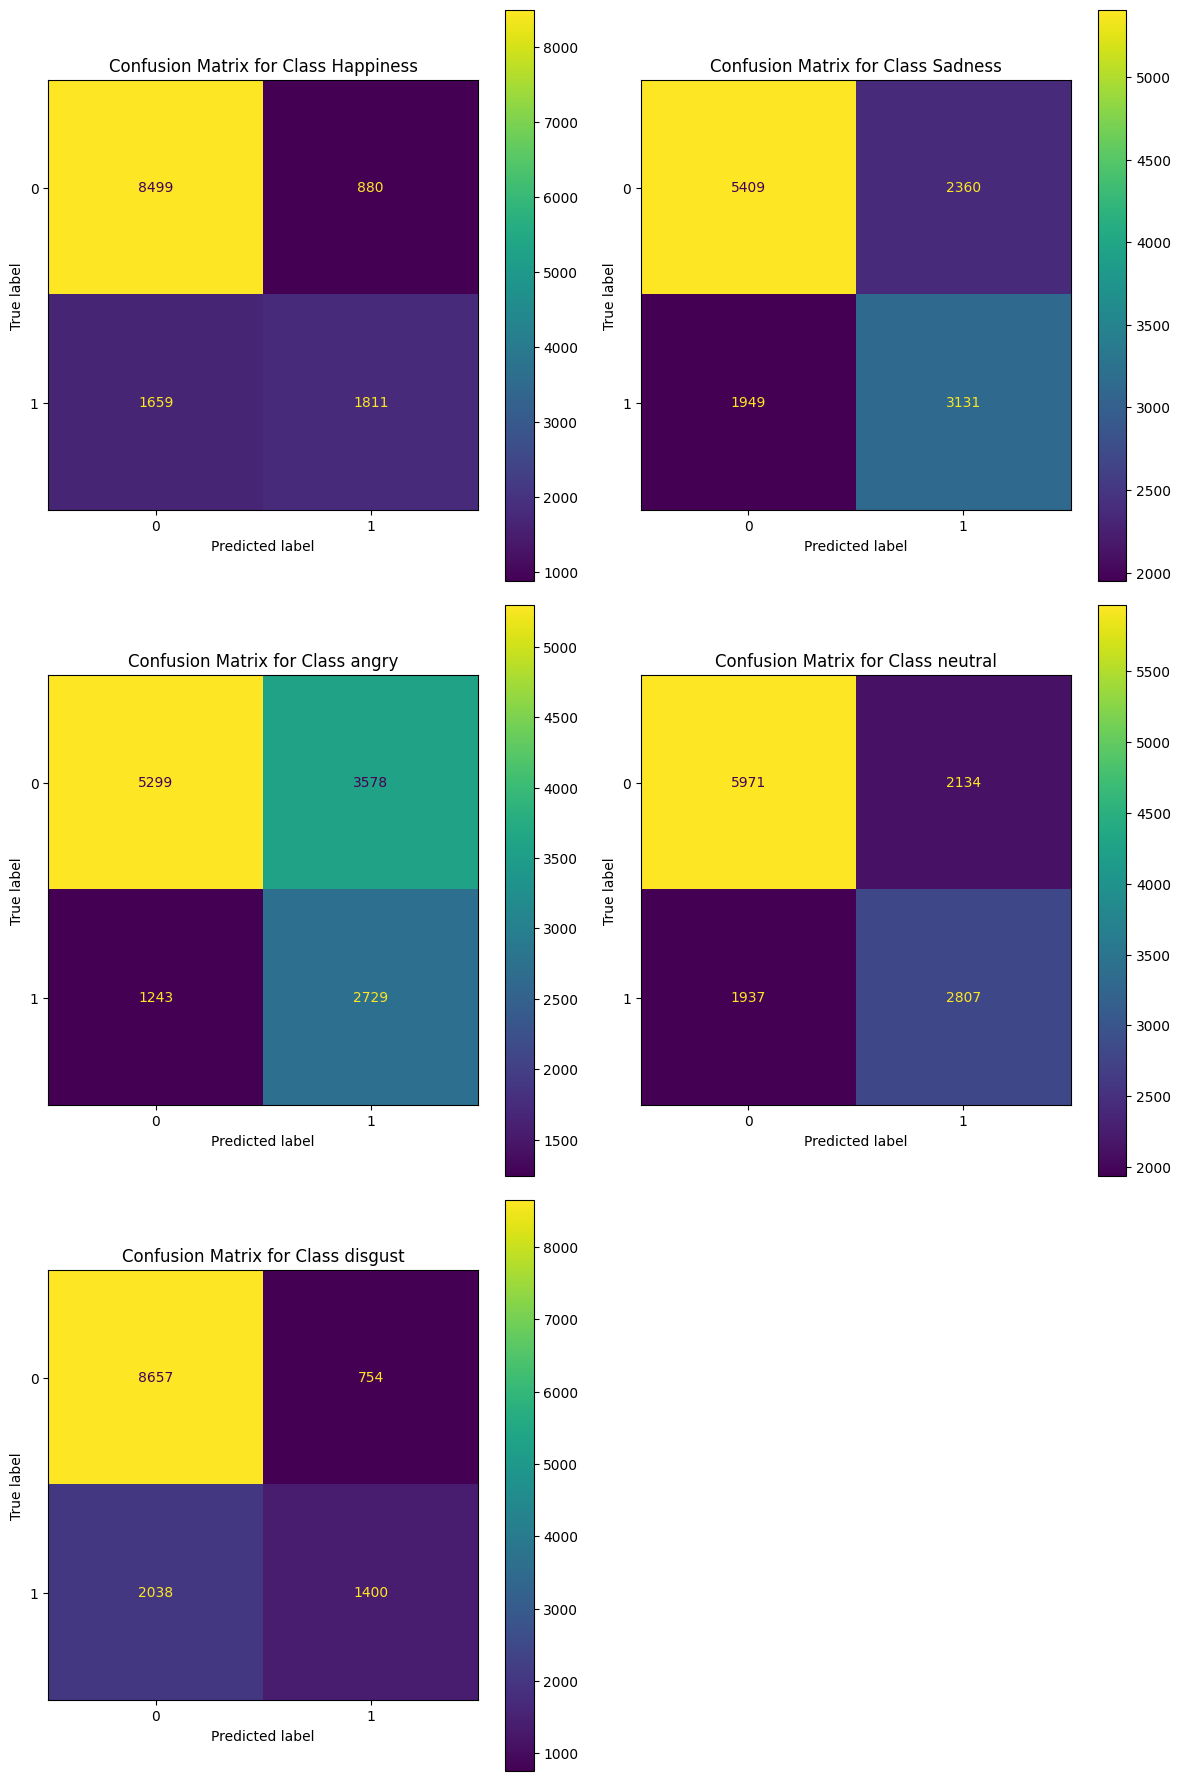

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_num = {0: "Happiness", 1: "Sadness", 2: "angry", 3: "neutral", 4: "disgust"}

# 일단 통일성을 위해 thres 0.4인 경우 실행결과 값의 confusion matrix를 확인
custom_y_test = cal_pred1.copy()
num_classes = 5

fig, axes = plt.subplots(3, 2, figsize = (12,18))

for class_idx in range(num_classes):
    class_true = y_test[:, class_idx]
    class_pred = custom_y_test[:, class_idx]

    # 혼동 행렬 계산
    cm = confusion_matrix(class_true, class_pred)

    # subplot 인덱스 계산(열로 나누면 )
    row_idx = class_idx // 2
    col_idx = class_idx % 2

    # 혼동 행렬 플롯
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)

    # 플롯 설정

    axes[row_idx, col_idx].set_title(f'Confusion Matrix for Class {label_num[class_idx]}')
    axes[row_idx, col_idx].set_xlabel('Predicted Label')
    axes[row_idx, col_idx].set_ylabel('True Label')
    disp.plot(ax = axes[row_idx, col_idx])
    axes[row_idx, col_idx].grid(False)

axes[2, 1].axis('off') # 나머지인 3행 2열 axes는 정보가 없으므로 끈다. (2,1)인 이유는 시작 idx가 0이기에 그렇다.
plt.tight_layout()
plt.show()

In [11]:
accuracy = accuracy_score(y_test, cal_pred1)
print(f"0.4일때 accuarcy 값: {accuracy}") # 정확히 맞춘경우

def trans_to_series(pred_list):
    return pd.Series(["".join(list(map(str,map(int, i)))) for i in pred_list]).value_counts()

cal_pred1 = pd.DataFrame(trans_to_series(cal_pred1)).reset_index()
cal_pred2 = pd.DataFrame(trans_to_series(cal_pred2)).reset_index()
answer = pd.DataFrame(trans_to_series(y_test)).reset_index()


agg_df = pd.merge(cal_pred1, cal_pred2, right_on = "index", left_on = "index", how = "outer")
agg_df = pd.merge(agg_df, answer, right_on = "index", left_on = "index", how = "outer")
agg_df.columns = ["index", "pred_0.4","pred_0.5","answer"]
agg_df.fillna(0, inplace = True)
agg_df.iloc[:,1:] = agg_df.iloc[:,1:].astype("int")
print(agg_df)

0.4일때 accuarcy 값: 0.262977663631411
    index  pred_0.4  pred_0.5  answer
0   00110      2096       848     799
1   01000      1806      1867    1013
2   01100      1296       428     982
3   00100      1170      2463    1106
4   00101      1102       826    1085
5   10010      1010       568    1114
6   11000       915       707    1317
7   00010       863      1647    1069
8   10000       621       939    1039
9   01001       529       465     796
10  01010       389        52     972
11  01101       223        31       0
12  01110       218         2       0
13  00000       166      1660       0
14  00111       150        25       0
15  00011        94        85     790
16  11010        93        10       0
17  00001        55       226     767
18  10110        27         0       0
19  11100        21         0       0
20  10100         4         0       0
21  01011         1         0       0
